In [ ]:
#Adjustments 
#Add input feature ranking to detemine which features to use
#Hyperparameter tuning
#Double check what i did with the nans

In [25]:
#Importing Libraries
from data_loader import FootballDataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

Reading game 1: Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Loading Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Data read.
Time shape: (155541, 2)
Ball shape: (155541, 6)
Team shape: (155541, 75)
Opponent shape: (155541, 80)
Total shape: (88002, 163)

=== DataFrame Overview ===
Shape: (88002, 163)

Columns:
['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Speed?', 'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y', 'FCKplayer_1_z', 'FCKplayer_1_speed_x', 'FCKplayer_1_number', 'FCKplayer_2_x', 'FCKplayer_2_y', 'FCKplayer_2_z', 'FCKplayer_2_speed_x', 'FCKplayer_2_number', 'FCKplayer_4_x', 'FCKplayer_4_y', 'FCKplayer_4_z', 'FCKplayer_4_speed_x', 'FCKplayer_4_number', 'FCKplayer_8_x', 'FCKplayer_8_y', 'FCKplayer_8_z', 'FCKplayer_8_speed_x', 'FCKplayer_8_number', 'FCKplayer_10_x', 'FCKplayer_10_y', 'FCKplayer_10_z', 'FCKplayer_10_speed_x', 'FCKplayer_10_number', 'FCKplayer_11_x', 'FCKplayer_11_y', 'FCKplayer_11_z', 'FCKplayer_11_speed_x', 'FCKplayer_11_number', 'FCKplayer_13_x', 'FCKpl

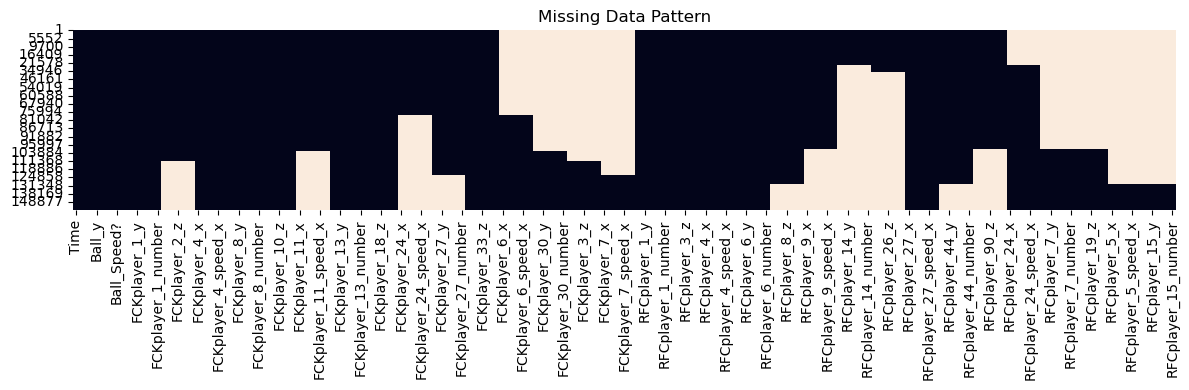

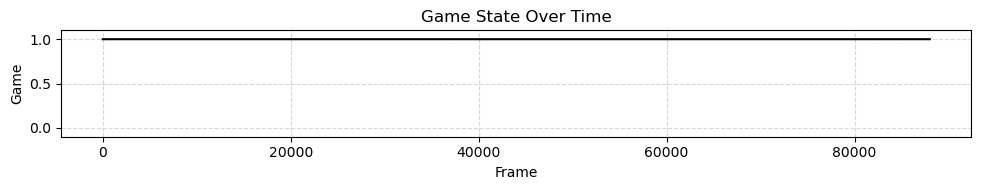

In [26]:
#Getting the data
data_dir = r"\Users\kirlo\Documents\Sanvi University Work\Year 3\AML\final project\FootballData\RestructuredData_2425"  # replace with your actual data directory
team = "FCK"         
data_retriever = FootballDataLoader(data_dir, team)
all_games = data_retriever.load_all_games()
game = all_games[0]

In [27]:
#Lets structure the data for NN
n_time_steps = game.shape[0]
#Obtaining relevant columns
position_columns = [
    col for col in game.columns 
    if (
        ('player' in col and (col.endswith('_x') or col.endswith('_y')) or 'speed' )  or 
        ('ball' in col.lower() and (col.endswith('_x') or col.endswith('_y') or 'speed' or col.endswith('_z') in col.lower()))
    )
]

game_reduced = game[position_columns]
game_reduced.columns

Index(['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Speed?',
       'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y',
       ...
       'RFCplayer_5_x', 'RFCplayer_5_y', 'RFCplayer_5_z',
       'RFCplayer_5_speed_x', 'RFCplayer_5_number', 'RFCplayer_15_x',
       'RFCplayer_15_y', 'RFCplayer_15_z', 'RFCplayer_15_speed_x',
       'RFCplayer_15_number'],
      dtype='object', length=163)

In [28]:
#Normalizing the data
game_reduced = (game_reduced - game_reduced.mean()) / game_reduced.std()

In [30]:
#Choose a smaller window size for sequence generation
window_size = 50  
horizon = 20
# Reshaping the data with window sliding method
def create_sequences(data, time_steps, future_steps):
    sequences = []
    targets = []
    for i in range(len(data) - time_steps - future_steps + 1):
        seq = data[i : i + time_steps]
        target = data[i + time_steps + future_steps - 1]  # predict future point
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)



input, _ = create_sequences(game_reduced.values, window_size, horizon)
target_x = game_reduced['FCKplayer_1_x'].values[window_size + horizon - 1:]  # Align with sequence targets
target_y = game_reduced['FCKplayer_1_y'].values[window_size + horizon - 1:]  

# Ensure input and targets have the same length
input = input[:len(target_x)]

# Splitting the data into training and testing sets
input_train, input_test, target_x_train, target_x_test, target_y_train, target_y_test = train_test_split(
    input, target_x, target_y, test_size=0.2, random_state=42
)


In [31]:
#Make the GRU
model = Sequential()
model.add(GRU(64, input_shape=(window_size, len(position_columns)), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')


c:\Users\kirlo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
import numpy as np

print(np.isnan(input_train).any(), np.isnan(input_test).any())
print(np.isinf(input_train).any(), np.isinf(input_test).any())


True True
False False


In [33]:
#This is me sorting the nans but idk if this is the best way to do it
input_train = np.nan_to_num(input_train, nan=0.0, posinf=0.0, neginf=0.0)
input_test = np.nan_to_num(input_test, nan=0.0, posinf=0.0, neginf=0.0)
target_x_train = np.nan_to_num(target_x_train, nan=0.0, posinf=0.0, neginf=0.0)
target_x_test = np.nan_to_num(target_x_test, nan=0.0, posinf=0.0, neginf=0.0)
target_y_train= np.nan_to_num(target_y_train, nan=0.0, posinf=0.0, neginf=0.0)
target_y_test = np.nan_to_num(target_y_test, nan=0.0, posinf=0.0, neginf=0.0)


In [34]:
#Training the model
history = model.fit(
    input_train, 
    np.column_stack((target_x_train, target_y_train)), 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2)

Epoch 1/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - loss: 0.1635 - val_loss: 0.0384
Epoch 2/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - loss: 0.0586 - val_loss: 0.0315
Epoch 3/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - loss: 0.0464 - val_loss: 0.0230
Epoch 4/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - loss: 0.0396 - val_loss: 0.0209
Epoch 5/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 65s 37ms/step - loss: 0.0367 - val_loss: 0.0167
Epoch 6/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - loss: 0.0338 - val_loss: 0.0141
Epoch 7/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 63s 36ms/step - loss: 0.0316 - val_loss: 0.0136
Epoch 8/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 65s 37ms/step - loss: 0.0307 - val_loss: 0.0123
Epoch 9/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 79s 45ms/step - loss: 0.0298 - val_loss: 0.0113
Epoch 10/10
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - loss: 0.0277 - val_loss: 0.0129


In [35]:
#Predicting the test set
predictions = model.predict(input_test)
# Extracting the predicted x and y positions
predicted_x = predictions[:, 0]
predicted_y = predictions[:, 1]



550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


In [36]:
predicted_x

array([ 0.0486967 ,  0.4046066 ,  0.89751536, ..., -0.6451862 ,
        1.1190033 ,  1.0117264 ], dtype=float32)

In [37]:
predicted_y

array([ 0.00739907,  0.05087804, -1.0864412 , ..., -0.18974152,
       -0.46068367,  0.58662087], dtype=float32)

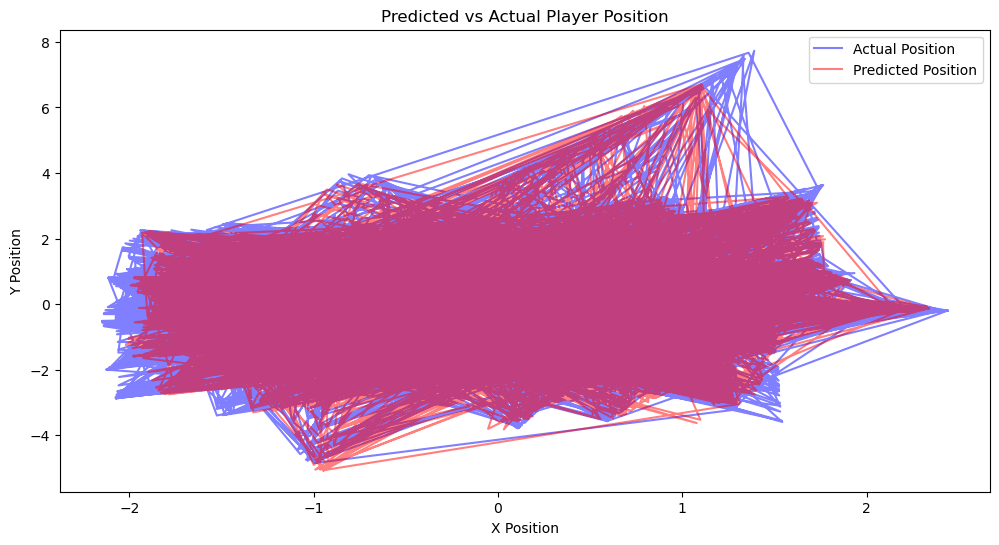

In [38]:
#Plotting predicted positions and actual positions
plt.figure(figsize=(12, 6))
plt.plot(target_x_test, target_y_test, label='Actual Position', color='blue', alpha=0.5)
plt.plot(predicted_x, predicted_y, label='Predicted Position', color='red', alpha=0.5)
plt.title('Predicted vs Actual Player Position')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()
